In [4]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

In [5]:
class RidgeRegression(BaseEstimator, RegressorMixin): ## BaseEstimator를 상속받으면 GridSearchCV를 쓸 수 있다.
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs) ## ## _는 convention 같은거임.내부적으로 사용되는 변수라는 뜻이며 다른 기본 키워드들과의 충돌을 피하기 위함.
        self.w_ = minimize(ridge_obj, w_0).x ## sklearn의 minimize함수. .x는 최적화 결과로 얻은 값들(weight값들)을 리턴함.
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")  ## getattr(object, 'x') 은 object.x와 완전히 동일하다.
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)

In [6]:
def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

In [35]:
def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
#     param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
#                                            np.arange(1,3,.3)
#                                              ))) }]
    param_grid = [{'l2reg':np.unique(np.arange(0.01,0.1,0.01))}]

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize, ### 음수로 바꿔서 최대화 하는 것은 원래것을 최소화 하는 것과 같다.
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

In [17]:
def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize=(6,12))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

In [29]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
    fig, ax = plt.subplots(figsize = (20,12))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, label='Training data')
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

In [13]:
def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
    fig, ax = plt.subplots()
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter
    fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"])
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

# 두번째 그래프
 - lambda = 1e-2정도에서 validation 데이터에 대한 mse가 최소이다
 
# 3번째 그래프
 - 자세히 보면 ridge의 그래프들은 계단처럼 생겼는데 모든 input이 binary 형태로 되어있기 때문이다.
 - lambda가 작으면 오버피팅되는 경향이 커짐을 알 수 있다.
 - 첫번째 그래프에서 lambda가 0.01인 경우가 mse가 제일 작았는데 lamda = 0.01이여도 target function과는 거리가 있다. 노이즈에 너무 fitting됨.
 
 # 4번째 그래프
  - ridge는 sparse하지 않은 파라미터를 가지게 해준다. lambda가 커질수록 sparsity가 작아지고 있다.

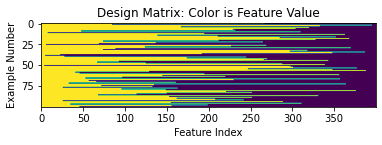

Hoping this is very close to 0:4.672889924502406e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000010         0.172464          0.006752
2      0.000100         0.171345          0.006774
3      0.001000         0.162705          0.008285
4      0.010000         0.141887          0.032767
5      0.100000         0.144566          0.094953
6      1.000000         0.171068          0.197694
7      1.300000         0.179521          0.216591
8      1.600000         0.187993          0.233450
9      1.900000         0.196361          0.248803
10     2.200000         0.204553          0.262958
11     2.500000         0.212530          0.276116
12     2.800000         0.220271          0.288422


<ipython-input-13-91a2c4365184>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-91a2c4365184>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-13-91a2c4365184>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


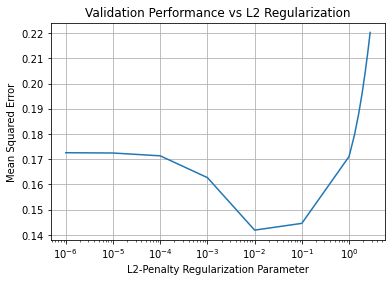

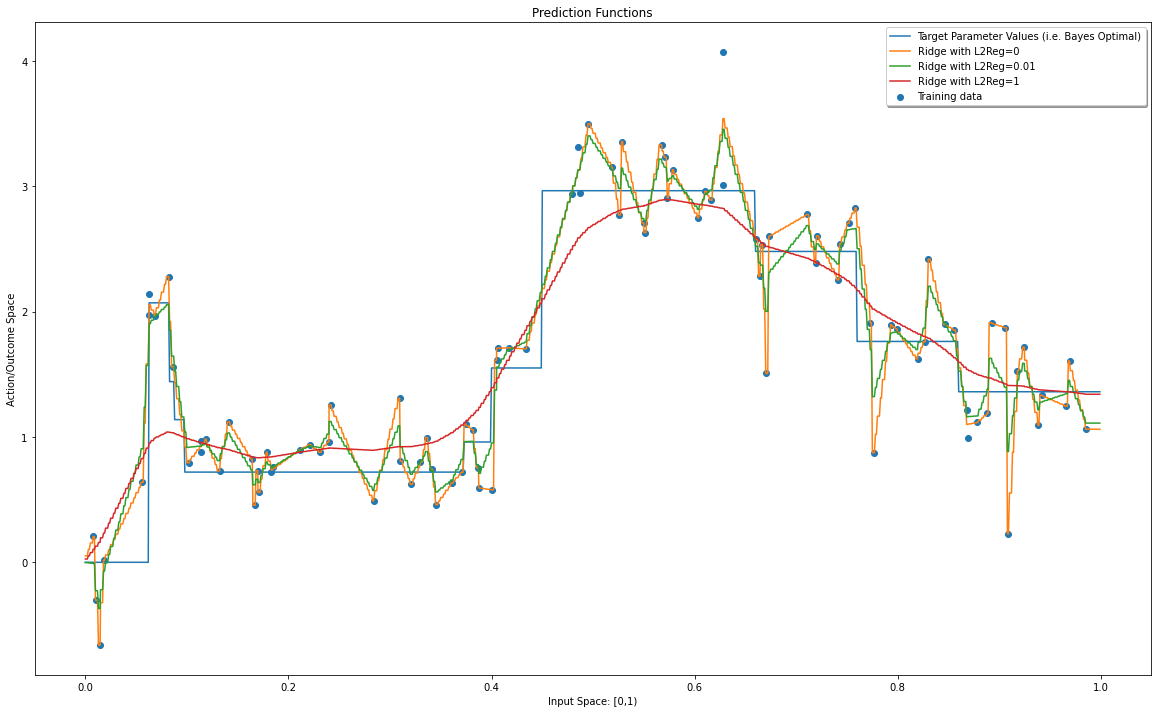

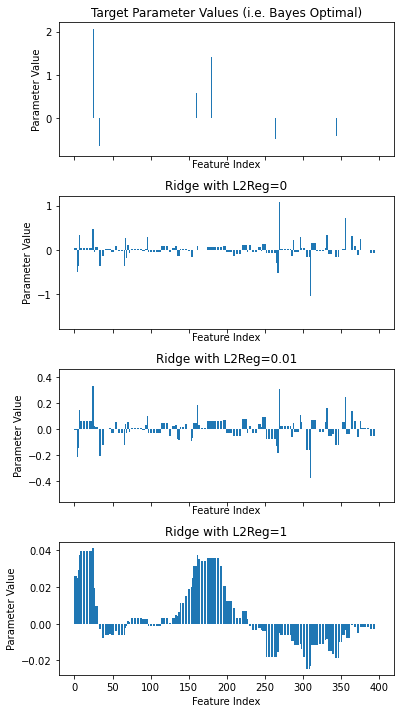

In [30]:
if __name__ == '__main__':
  main()

## 다른 lambda값에 대해서 실행.

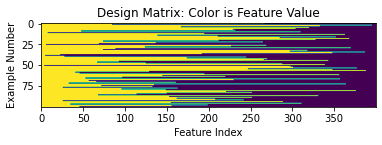

Hoping this is very close to 0:4.672889924502406e-11
   param_l2reg  mean_test_score  mean_train_score
0         0.01         0.141887          0.032767
1         0.02         0.139470          0.048579
2         0.03         0.139563          0.059124
3         0.04         0.140223          0.067087
4         0.05         0.141019          0.073522
5         0.06         0.141821          0.078948
6         0.07         0.142582          0.083649
7         0.08         0.143293          0.087808
8         0.09         0.143953          0.091548


<ipython-input-13-91a2c4365184>:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-13-91a2c4365184>:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-13-91a2c4365184>:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


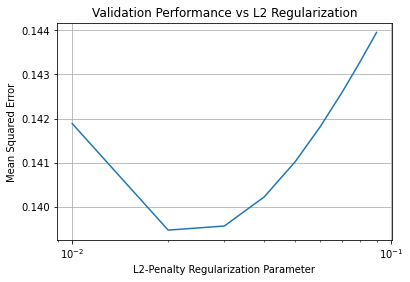

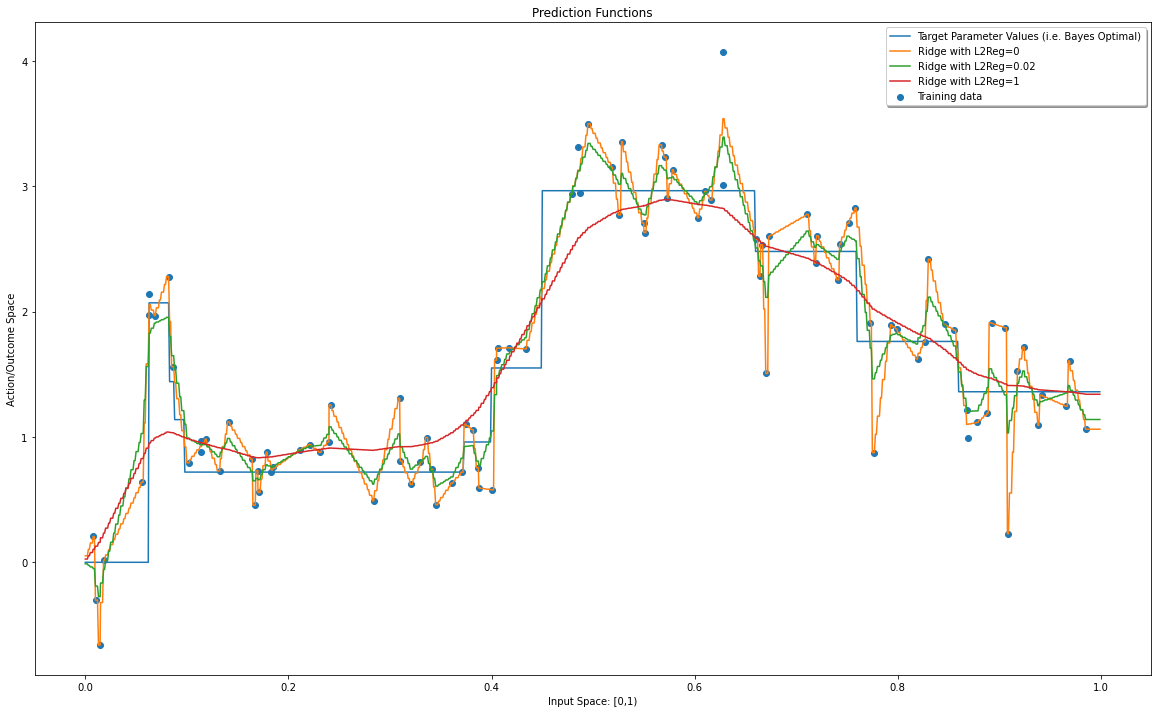

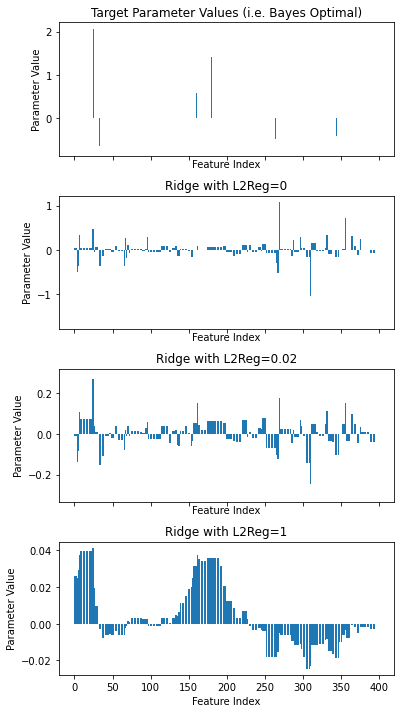

In [36]:
if __name__ == '__main__': 
  main()

In [21]:
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

In [22]:
x_train

array([0.66656527, 0.21099131, 0.98576502, 0.83007921, 0.4173425 ,
       0.79914531, 0.75793622, 0.57063288, 0.57901931, 0.11847408,
       0.7728778 , 0.01846007, 0.48549037, 0.90532834, 0.34524665,
       0.52598929, 0.87812873, 0.71102939, 0.91785725, 0.81949944,
       0.52841268, 0.18444641, 0.66066791, 0.34151433, 0.17131441,
       0.0145817 , 0.67005126, 0.56746115, 0.30953677, 0.92460315,
       0.22157251, 0.18305074, 0.7936761 , 0.7412013 , 0.96562532,
       0.86924979, 0.47947701, 0.05568619, 0.01052375, 0.06852684,
       0.61011903, 0.43422072, 0.67360635, 0.66433739, 0.85583472,
       0.23127884, 0.16737973, 0.3100852 , 0.71910866, 0.84699593,
       0.00771939, 0.74271395, 0.75167063, 0.94228665, 0.61627136,
       0.86785038, 0.96914286, 0.32087559, 0.10226573, 0.11437291,
       0.48689924, 0.88819266, 0.36110722, 0.549953  , 0.24197779,
       0.13234472, 0.89236379, 0.57310452, 0.14130257, 0.1643654 ,
       0.40078095, 0.08202477, 0.90844137, 0.33647625, 0.17849

In [23]:
x_train.shape

(100,)

In [27]:
X_train[1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
X_train.shape

(100, 400)

In [31]:
10.**np.arange(-6,1,1)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])

In [32]:
np.arange(1,3,.3)

array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8])

In [34]:
np.arange(0.01,0.1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])